In [1]:
!pip install stellargraph[demos]

  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)


  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.0
    Uninstalling numpy-1.18.0:
      Successfully uninstalled numpy-1.18.0
  Rolling back uninstall of numpy
  Moving to /home/jovyan/.local/bin/f2py
   from /tmp/pip-uninstall-fxl1gxtp/f2py
  Moving to /home/jovyan/.local/bin/f2py3
   from /tmp/pip-uninstall-fxl1gxtp/f2py3
  Moving to /home/jovyan/.local/bin/f2py3.7
   from /tmp/pip-uninstall-fxl1gxtp/f2py3.7
  Moving to /home/jovyan/.local/lib/python3.7/site-packages/numpy-1.18.0.dist-info/
   from /home/jovyan/.local/lib/python3.7/site-packages/~umpy-1.18.0.dist-info
  Moving to /home/jovyan/.local/lib/python3.7/site-packages/numpy/
   from /home/jovyan/.local/lib/python3.7/site-packages/~-mpy
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/home/user/conda/lib/python3.7/site-packages/numpy/_distributor_init.py'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the '/home/user/

In [3]:
!pip install networkx

You should consider upgrading via the '/home/user/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random
from tqdm import tqdm

pd.set_option('display.max_columns', 500)
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split
import networkx as nx
from stellargraph.mapper import GraphWaveGenerator
from stellargraph import StellarGraph
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse.linalg import eigs
import tensorflow as tf
from tensorflow.keras import backend as K


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

from stellargraph import datasets
from IPython.display import display, HTML

## DATASET PROCESING

Загружаем граф:

In [6]:
graph = pd.read_csv("graph_abakan_F_encoded.csv",index_col = 0)

Генерируем edge list:

In [7]:
def get_index_tuples(df):
    lst = []
    for i in tqdm(range(len(df))):
        tmp = df['adjacent'][i].split(',')
        for edge in tmp:
            lst.append([i, int(edge)])
            
    return lst
lst = get_index_tuples(graph)
lst = pd.DataFrame(lst)

100%|██████████| 65524/65524 [00:04<00:00, 13167.37it/s]


In [8]:
edge_data = pd.DataFrame(
    {
        "source": list(lst[0]),
        "target": list(lst[1])
    }
)

In [9]:
node_data = graph.drop(["edge_id", "adjacent", "style_<pandas.io.formats.style.Styler object at 0x000001B5DF375370>"], axis = 1)

In [10]:
node_data

,length,width,rm_car_speed,type,light_begin,light_end,turn_to,payments_flags,is_city_edge,barrier,turn_restrictions,traverse,passability,pedo_offset,bad_road,def_speed,road_exit,road_classes_1,road_classes_2,road_classes_3,road_classes_4,road_classes_5,road_classes_6,road_classes_7,road_classes_8,road_classes_9,sm_classes_0,sm_classes_1,sm_classes_2,sm_classes_3,sm_classes_4,sm_classes_5,sm_classes_6,sm_classes_7,sm_classes_8,sm_classes_9,sm_classes_10,sm_classes_11,sm_classes_12,sm_classes_13,sm_classes_14,sm_classes_15,sm_classes_16,sm_classes_17,sm_classes_18,sm_classes_19,sm_classes_20,sm_classes_21,sm_classes_22,sm_classes_23,sm_classes_24,sm_classes_25,sm_classes_26,lanes_0,lanes_1,lanes_2,lanes_3,rm_car_classes_0,rm_car_classes_1,rm_car_classes_2,rm_car_classes_3,rm_car_classes_4,rm_car_classes_5,rm_car_classes_6,rm_car_classes_7,rm_car_classes_8,rm_car_classes_9,rm_car_classes_10,rm_car_classes_11,rm_car_classes_12,rm_car_classes_13,rm_car_classes_14,rm_car_classes_15
0,104,7,90,0,0,0,0,0,0,0,0,1,1,0,0,90,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,104,7,90,0,0,0,0,0,0,0,0,1,1,0,0,90,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,553,3,90,0,0,0,1,0,0,0,0,1,1,0,0,90,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,553,3,90,0,0,0,1,0,0,0,0,1,1,0,0,90,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,500,7,90,0,0,0,0,0,0,0,0,1,1,0,0,90,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65519,91,3,60,0,0,0,1,0,1,0,0,1,1,0,0,60,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
65520,144,3,60,0,0,0,1,0,1,0,0,1,1,0,0,60,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
65521,144,3,60,0,0,0,1,0,1,0,0,1,1,0,0,60,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
65522,58,3,60,0,0,0,1,0,1,0,0,1,1,0,0,60,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [9]:
G = sg.StellarGraph(
    {"street": node_data}, {"connection": edge_data}
)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 65524, Edges: 340012

 Node types:
  street: [65524]
    Features: float32 vector, length 73
    Edge types: street-connection->street

 Edge types:
    street-connection->street: [340012]
        Weights: all 1 (default)
        Features: none


In [10]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model

In [22]:
graphsage_generator = GraphSAGENodeGenerator(G, batch_size=1000, num_samples=[5])

graphsage_model = GraphSAGE(
    layer_sizes=[128], activations=["relu"], generator=graphsage_generator
)
corrupted_generator = CorruptedGenerator(graphsage_generator)
gen = corrupted_generator.flow(G.nodes())

infomax = DeepGraphInfomax(graphsage_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

Epoch 1/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.4654
Epoch 2/1000
66/66 [==============================] - 2s 33ms/step - loss: 0.4392
Epoch 3/1000
66/66 [==============================] - 2s 37ms/step - loss: 0.4384
Epoch 4/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.4340
Epoch 5/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.4400
Epoch 6/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.4443
Epoch 7/1000
66/66 [==============================] - 2s 36ms/step - loss: 0.4368
Epoch 8/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.4395
Epoch 9/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.4309
Epoch 10/1000
66/66 [==============================] - 2s 33ms/step - loss: 0.4463
Epoch 11/1000
66/66 [==============================] - 2s 36ms/step - loss: 0.4369
Epoch 12/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.4495
Epoch 13/1000

66/66 [==============================] - 3s 51ms/step - loss: 0.3723: 
Epoch 196/1000
66/66 [==============================] - 3s 50ms/step - loss: 0.3969
Epoch 197/1000
66/66 [==============================] - 3s 51ms/step - loss: 0.3801
Epoch 198/1000
66/66 [==============================] - 11s 169ms/step - loss: 0.3750
Epoch 199/1000
66/66 [==============================] - 3s 52ms/step - loss: 0.3748
Epoch 200/1000
66/66 [==============================] - 3s 50ms/step - loss: 0.3836
Epoch 201/1000
66/66 [==============================] - 3s 51ms/step - loss: 0.3719
Epoch 202/1000
66/66 [==============================] - 4s 55ms/step - loss: 0.3725
Epoch 203/1000
66/66 [==============================] - 3s 53ms/step - loss: 0.3766
Epoch 204/1000
66/66 [==============================] - 3s 51ms/step - loss: 0.4026
Epoch 205/1000
66/66 [==============================] - 11s 163ms/step - loss: 0.3832
Epoch 206/1000
66/66 [==============================] - 3s 50ms/step - loss: 0.3781
E

66/66 [==============================] - 2s 35ms/step - loss: 0.3619
Epoch 390/1000
66/66 [==============================] - 2s 33ms/step - loss: 0.3455
Epoch 391/1000
66/66 [==============================] - 2s 36ms/step - loss: 0.3533
Epoch 392/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.3553
Epoch 393/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.3513
Epoch 394/1000
66/66 [==============================] - 2s 37ms/step - loss: 0.3497
Epoch 395/1000
66/66 [==============================] - 10s 153ms/step - loss: 0.3537
Epoch 396/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.3491
Epoch 397/1000
66/66 [==============================] - 2s 36ms/step - loss: 0.3426
Epoch 398/1000
66/66 [==============================] - 2s 37ms/step - loss: 0.3897
Epoch 399/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.3613
Epoch 400/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.3637
Epoch

66/66 [==============================] - 2s 35ms/step - loss: 0.3417
Epoch 584/1000
66/66 [==============================] - 2s 36ms/step - loss: 0.3351
Epoch 585/1000
66/66 [==============================] - 2s 33ms/step - loss: 0.3390
Epoch 586/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.3494
Epoch 587/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.3513
Epoch 588/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.3410
Epoch 589/1000
66/66 [==============================] - 10s 151ms/step - loss: 0.3357
Epoch 590/1000
66/66 [==============================] - 3s 37ms/step - loss: 0.3354: 0s -
Epoch 591/1000
66/66 [==============================] - 2s 36ms/step - loss: 0.3458
Epoch 592/1000
66/66 [==============================] - 2s 37ms/step - loss: 0.3363
Epoch 593/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.3530
Epoch 594/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.3387

66/66 [==============================] - 2s 35ms/step - loss: 0.3550
Epoch 778/1000
66/66 [==============================] - 2s 33ms/step - loss: 0.3299
Epoch 779/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.3266
Epoch 780/1000
66/66 [==============================] - 11s 168ms/step - loss: 0.3319
Epoch 781/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.3378
Epoch 782/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.3371
Epoch 783/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.3331
Epoch 784/1000
66/66 [==============================] - 2s 37ms/step - loss: 0.3321
Epoch 785/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.3333
Epoch 786/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.3295
Epoch 787/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.3361
Epoch 788/1000
66/66 [==============================] - 11s 174ms/step - loss: 0.3403
Epo

66/66 [==============================] - 11s 166ms/step - loss: 0.3324
Epoch 875/1000
66/66 [==============================] - 2s 36ms/step - loss: 0.3359
Epoch 876/1000
66/66 [==============================] - 2s 36ms/step - loss: 0.3208
Epoch 877/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.3369
Epoch 878/1000
66/66 [==============================] - 3s 38ms/step - loss: 0.3323
Epoch 879/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.3450
Epoch 880/1000
66/66 [==============================] - 2s 35ms/step - loss: 0.3438
Epoch 881/1000
66/66 [==============================] - 2s 37ms/step - loss: 0.3354
Epoch 882/1000
66/66 [==============================] - 10s 157ms/step - loss: 0.3351
Epoch 883/1000
66/66 [==============================] - 3s 38ms/step - loss: 0.3288
Epoch 884/1000
66/66 [==============================] - 2s 37ms/step - loss: 0.3395
Epoch 885/1000
66/66 [==============================] - 2s 37ms/step - loss: 0.3285
Epo

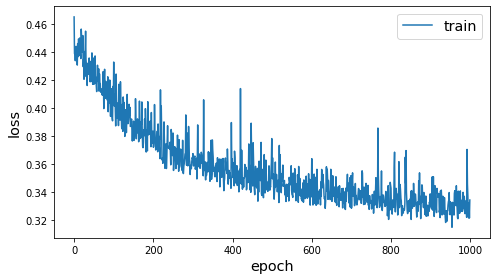

In [25]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(gen, epochs=1000, verbose=1)
plot_history(history)

In [35]:
x_emb_in, x_emb_out = graphsage_model.in_out_tensors()
# for full batch models, squeeze out the batch dim (which is 1)
if graphsage_generator.num_batch_dims() == 2:
    print("2")
    x_emb_out = tf.squeeze(x_emb_out, axis=0)

emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

In [36]:
node_gen = GraphSAGENodeGenerator(G, batch_size=1000, num_samples=[5]).flow(G.nodes())
node_embeddings = emb_model.predict(node_gen, workers=4, verbose=1)

66/66 [==============================] - 4s 45ms/step


In [44]:
pd.DataFrame(node_embeddings).to_csv("dgi_sage_128_5_relu_1100e_0.33l.csv")